# Side-Channel Analysis Lab 02: Leakage Analysis Tools

- *Course*: ISMIN, "Théorie et pratique des attaques par observation"
- *Year*: 2023
- *Initial Author*: [Thomas Hiscock](mailto:thomas.hiscock@cea.fr), CEA-LETI (LTSO Laboratory)
- *Modified by*: [Arsene Baert](arsene.baert@etu.emse.fr) 

In this tutorial, we will perform some basic leakage analysis on side-channel traces.
We will work on traces obtained  with an STM32 processing AES on different plain test.

## Imports

In [2]:
import collections

import numpy as np
import matplotlib.pyplot as plt
from utils import hamming_weight, aes_sbox


## Load Traces
We load our traces stored in csv in a numpy array.


In [3]:
# For csv
file_name = "../../Data/Trace_csv/20230130-0001 (1).csv"
full_trace_em_str = np.loadtxt("../../Data/Trace_csv/20230130-0001 (1).csv", dtype=str, delimiter=';', skiprows=3)
full_trace_em_str = full_trace_em_str[:,1]  # The first column contain time data but is not relevant because each point is ordered by time (first point first gathered)
full_trace_em_str = np.char.replace(full_trace_em_str, ',', '.')  # Our data collection program used comas instead of points
full_trace_em_str = np.char.replace(full_trace_em_str, 'âˆž', '100')  # When a saturation on our data was recorded (>100mV or <100mv), it was replaced by an infinite signed, written âˆž in str, we replace it by 100
trace_em = full_trace_em_str.astype(float)  # Transform our str type data to float
full_trace_em = trace_em

for i in range(2,301):  # Repeat for our 300 traces
    i_str = str(i)
    file_name = "../../Data/Trace_csv/20230130-0001 (" + i_str  + ").csv"
    full_trace_em_str = np.loadtxt(file_name, dtype=str, delimiter=';', skiprows=3)
    full_trace_em_str = full_trace_em_str[:,1]
    full_trace_em_str = np.char.replace(full_trace_em_str, ',', '.')
    full_trace_em_str = np.char.replace(full_trace_em_str, 'âˆž', '100')
    trace_em = full_trace_em_str.astype(float)
    full_trace_em = np.row_stack((full_trace_em, trace_em))

print(full_trace_em)
print(np.shape(full_trace_em))

[[ -3.949311    0.7874015  -7.898622  ...  -7.108144  -33.17852
  -29.22613  ]
 [ -6.317667    0.7874015  -3.158834  ...  -7.108144  -30.80709
  -33.96592  ]
 [  8.689098   -1.577879   -2.368356  ... -10.26698   -22.11799
  -37.9183   ]
 ...
 [ 12.63841    -2.368356   -3.158834  ... -16.58772   -16.58772
  -37.9183   ]
 [ -2.368356   -0.7874015  -5.52719   ...  -6.317667  -33.96592
  -31.59756  ]
 [  0.         -1.577879   -1.577879  ...  -7.108144  -26.0673
  -37.12783  ]]
(300, 2504)


## Example of trace

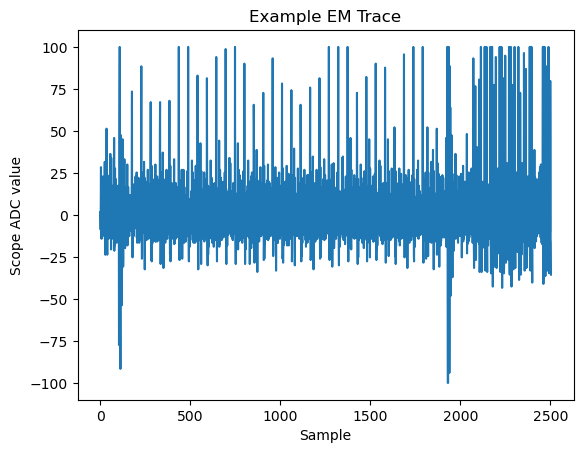

In [4]:
plt.plot(full_trace_em[29])
plt.xlabel("Sample")
plt.ylabel("Scope ADC value")
plt.title("Example EM Trace")
plt.show()

## Load plain text

In [51]:
file_name = "../../Data/pText.txt"
p_texts = np.loadtxt(file_name, dtype=str)
p_texts[0][:2]
print(p_texts, np.shape(p_texts))

['3633f1e7147bc067445d6b5de5677bd4' '18d46a264e121a4ba23319b52cd25370'
 'b1d67c63b5c9bc79005b59025c9748d4' ... '97388406ea5d1916380313a25ace3514'
 'b82ff45942f4a70ef5a740068b16719d' 'b0127e0fdeeb2b96acf8d60ff4210b55'] (5000,)


## Implementation of our model
Our model will replicate the functionment of the SubBytes function in AES and calculate the Hamming weight of the result. It will take in argument the first byte of the plain text and a byte respresenting one byte of our key.

In [65]:
SBOXFile = open("../../Data/sbox_dec.txt", "r")

SBox = np.zeros(256, dtype=np.int32)

for i in range(256):
    SBox[i] = SBOXFile.readline()[:-2]

def model(p_text_byte, k_byte):
    return hamming_weight(aes_sbox(k_byte ^ p_text_byte))

def gen_array(p_text):
    hyp_array = np.zeros((256, 300), dtype=int)
    for i in range(256):
        for j in range(300):
            hyp_array[i][j] = model(int(p_text[j][0:2], 16), i)
    return hyp_array

print(gen_array(p_texts), np.shape(gen_array(p_texts)))

[[2 5 3 ... 3 5 2]
 [4 4 6 ... 3 1 4]
 [2 3 5 ... 2 4 2]
 ...
 [5 5 3 ... 1 3 5]
 [4 4 2 ... 4 2 4]
 [6 3 5 ... 5 3 6]] (256, 300)


<span style="color: #21b6ff">**Questions:**</span>

- How many pattern can we identify in EM and power traces?
- What are the visual differences between EM and power?
- If a trace is made of 100000 ADC 8-bit samples (int8):
    - what would be the size **in bytes** of a single trace?
    - what would be the size **in gigabytes** of 10000 traces?

### Loading the traces

The traces shown in the previous section are too large to experiment easily. So, for the rest of this lab, we will work only on a subpart of the traces.

- `data_em`: contains the electro-magnetic traces
- `data_power`: contains the power traces

In [4]:
data_em = np.load("data/02_data_em.npy")

data_power = np.load("data/02_data_power.npy")

Both array are two dimensional arrays. Each row of the array corresponds to a single trace. Hence, `data[0]` is the first trace, `data[1]` is the second traces and so on.

<span style="color: #21b6ff">**Exercice 1:**</span> using your numpy knownledge, print the shape of both arrays. How many traces are available? How many samples are available?

In [6]:
# TODO
print("shape of data_em:", np.shape(data_em))
print("shape of data_power:", np.shape(data_power))

shape of data_em: (10000, 1000)
shape of data_power: (10000, 1000)


<span style="color: #21b6ff">**Exercice 2:**</span> plot traces 0 and 2 of the dataset.

<span style="color: #21b6ff">**Exercice 3:**</span> on EM or power traces, can you guess visually, where "interesting things" may happen?

## Basic Analysis

Lets try to automate this process of finding interesting regions. A first approach is to look at the variance of the signal. Why? Because a high variance indicates a high variability in the signal.

<span style="color: #21b6ff">**Exercice 4:**</span> compute the variance of EM and power traces.

- Use `np.var`
- We want to compute the variance "vertically" (i.e., column-wise). Thus, you have to pass the correct `axis=` argument to `np.var`

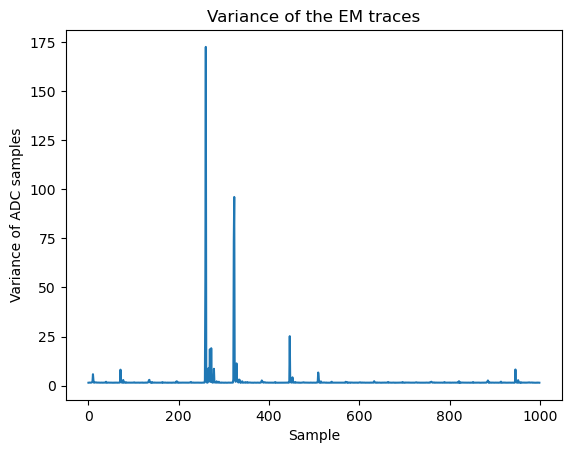

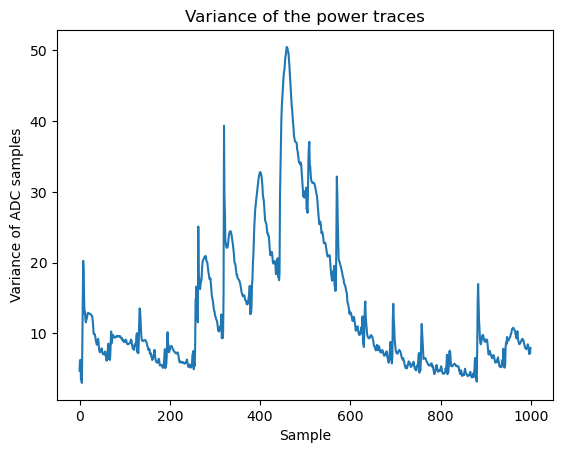

In [7]:
data_em_var = np.var(data_em, axis=0)
assert data_em_var.shape == (data_em.shape[1], )

plt.plot(data_em_var)
plt.xlabel("Sample")
plt.ylabel("Variance of ADC samples")
plt.title("Variance of the EM traces")
plt.show()

data_power_var = np.var(data_power, axis=0)
assert data_power_var.shape == (data_power.shape[1], )

plt.plot(data_power_var)
plt.xlabel("Sample")
plt.ylabel("Variance of ADC samples")
plt.title("Variance of the power traces")
plt.show()

With a simple variance, we can already spot some interesting samples to look at.

We can observe that many points on the EM have no variance at all and can probably be discarded from our analysis!

## Identifying 2-class leakages

Lets suppose each trace can be assigned a binary label. For example, traces where a key bit is 1 and traces where the same bit is 0. How can we identify in the traces where the separability of those two classes is maximized?

We will see two techniques:

- Difference of means
- Welch's T-Test

We provide the labeling of each traces in the `labels_binary` array:

In [8]:
labels_binary = np.load("data/02_labels_bin.npy")

print(labels_binary.dtype, labels_binary.shape)

bool (10000,)


This array provides 1 boolean for each trace. In other words, the class of the $i$-th trace is obtained with `labels_binary[i]`.

### Difference of Means

A very simple approach is to look at the mean trace in each group. This is known as the difference of means.

<span style="color: #21b6ff">**Exercice 5:**</span> compute the difference of means of the traces:

- Split the data in two groups, traces where `labels == True` and traces where `labels == False`. Remember that in Numpy, you can index an array with a boolean array (only the indices with value `True` will be kept).
- Compute the mean of `traces_of_group_0` and `traces_of_group_1`. We want to compute the mean "vertically" (i.e., column-wise). Thus, you have to pass the correct `axis=` argument to `np.mean`.

**Index a boolean table in a numpy array**

In [9]:
def difference_of_means(data, labels):
    traces_of_group_0 = data[labels == False]
    traces_of_group_1 = data[labels]  # We can also put == True
    
    mean_of_group_0 = np.mean(traces_of_group_0, axis=0)
    mean_of_group_1 = np.mean(traces_of_group_1, axis=0)
    
    return np.abs(mean_of_group_0 - mean_of_group_1)

Let's visualize the results:

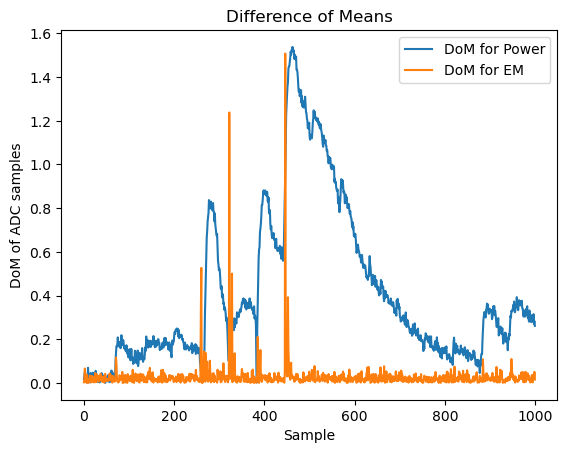

In [10]:
dom_power = difference_of_means(data_power, labels_binary)
plt.plot(dom_power, label="DoM for Power")

dom_em = difference_of_means(data_em, labels_binary)
plt.plot(dom_em, label="DoM for EM")

plt.legend()
plt.xlabel("Sample")
plt.ylabel("DoM of ADC samples")
plt.title("Difference of Means")
plt.show()

Can you see where the leakages are located?

We can zoom at the point where the metric is the highest.

Highest EM DoM is at sample 446


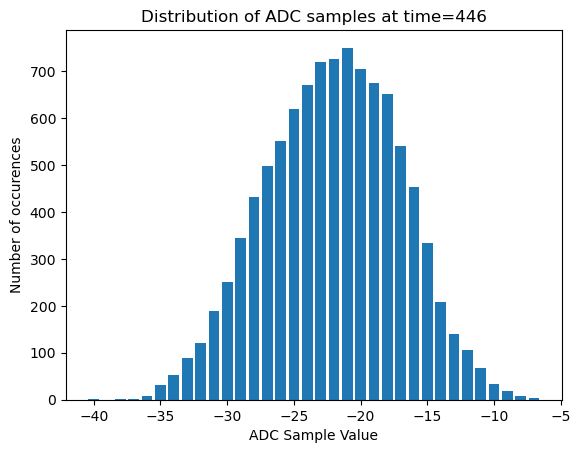

In [11]:
best_location = np.argmax(dom_em)
print("Highest EM DoM is at sample", best_location)

def build_histogram(data):
    cnt = collections.Counter(data)
    cnt_list = list(cnt.items())
    cnt_list.sort(key=lambda x: x[0])
    return [x for x, _ in cnt_list], [y for _, y in cnt_list]

xs_0, ys_0 = build_histogram(data_em[:, best_location])
plt.bar(xs_0, ys_0)
plt.xlabel("ADC Sample Value")
plt.ylabel("Number of occurences")
plt.title(f"Distribution of ADC samples at time={best_location}")
plt.show()

This does not gives a lot of information. Ideally, we would like to see clusters appear.

Let colorize this plot with the class of the data:

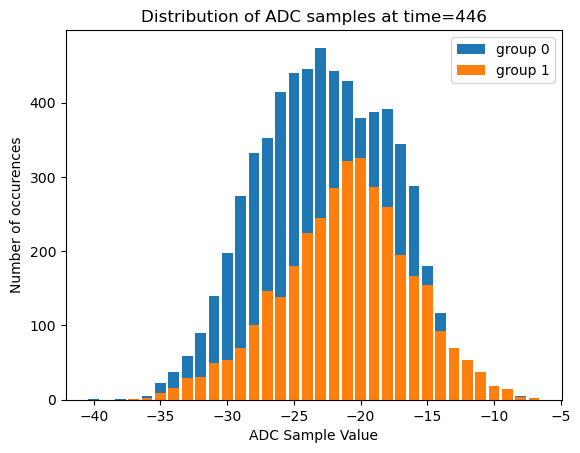

In [12]:
xs_0, ys_0 = build_histogram(data_em[labels_binary == False, best_location])
plt.bar(xs_0, ys_0, label="group 0")

xs_1, ys_1 = build_histogram(data_em[labels_binary == True, best_location])
plt.bar(xs_1, ys_1, label="group 1")

plt.legend()
plt.xlabel("ADC Sample Value")
plt.ylabel("Number of occurences")
plt.title(f"Distribution of ADC samples at time={best_location}")
plt.show()

**Problems of mean difference :**
- dif of nb of traces per class
- does not take into account the variance only the mean

### Welch's T-Test

The difference of mean approach is already effective in many cases. However, it has a major drawback: when the cardinal of each are different, the metric is not reliable.

Welch's T-Test resolves this issue. This metric is defined as:

$$
t = \frac{\overline{E}(X_0) - \overline{E}(X_1)}{\sqrt{\frac{\overline{Var}(X_0)}{N_0} + \frac{\overline{Var}(X_1)}{N_1}}}
$$

- $X_0$, $X_1$ represents traces in group 0 and 1
- $N_0$, $N_1$ are the number of traces in each group
- $\overline{E}(\cdot)$, $\overline{Var}(\cdot)$ are mean and variance estimators

<span style="color: #21b6ff" id="welch-solution">**Exercice 6:**</span> implement the `welch_t_test` function by filling the code below:

In [18]:
def welch_t_test(data, labels):
    traces_of_group_0 = data[labels == False]
    traces_of_group_1 = data[labels == True]
    size_of_g0 = traces_of_group_0.shape[0]
    size_of_g1 = traces_of_group_1.shape[0]
    
    mean_of_g0 = np.mean(traces_of_group_0, axis=0)
    mean_of_g1 = np.mean(traces_of_group_1, axis=0)
    
    var_of_g0 = np.var(traces_of_group_0, axis=0)
    var_of_g1 = np.var(traces_of_group_1, axis=0)
    
    numerator = mean_of_g0 - mean_of_g1
    denumerator = np.sqrt((var_of_g0/size_of_g0) + (var_of_g1/size_of_g1)) 
    
    return numerator / denumerator

Lets see the results. Usually, we consider that there is a leakage when the t-value is greater than 4.5.

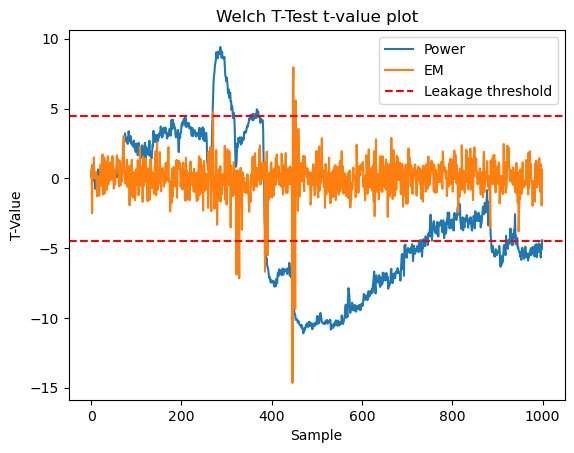

In [19]:
ttest_power = welch_t_test(data_power, labels_binary)
plt.plot(ttest_power, label="Power")

ttest_em = welch_t_test(data_em, labels_binary)
plt.plot(ttest_em, label="EM")

plt.axhline(y=4.5, color="r", linestyle="--", label="Leakage threshold")
plt.axhline(y=-4.5, color="r", linestyle="--")

plt.legend()
plt.xlabel("Sample")
plt.ylabel("T-Value")
plt.title("Welch T-Test t-value plot")
plt.show()

## Identifying N-class leakages (signal to noise ratio)

In the previous section, we learned how two identify leakages when there are two groups of traces. But how can we do when there are more than two classes?

One approach is to implement a signal to noise ratio. A signal to noise ratio is generally defined as:

$$
snr = \frac{Var(\text{useful signal})}{Var(\text{noise})}
$$

However, in side-channel analysis, it is not obvious what are the "useful signal" and the "noise". As we have seen with two classes, we generally look for **separability between classes**. More precisely, we want each class to have a **distinct mean from others**. Thus, our useful signal can be the mean ADC sample per class: $E(X | Z)$. 

Now, what would be the noise term? Well, rembember that our useful signal is the mean of each class. The noise we have is the variation around the mean in each class, that causes some overlapping between classes:

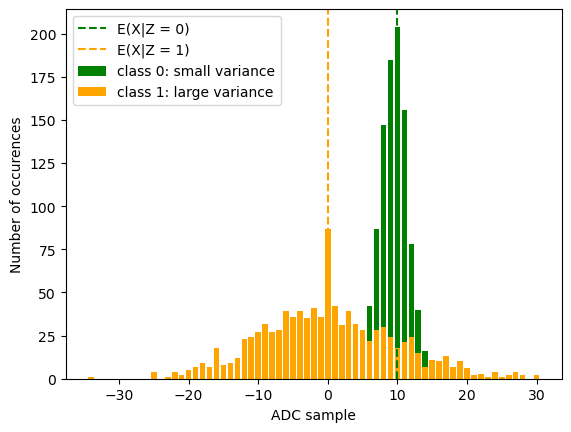

In [20]:
xs, ys = build_histogram(np.random.normal(10, scale=2, size=1000).astype(np.int16))
plt.bar(xs, ys, label="class 0: small variance", color="g")
plt.axvline(x=10, label="E(X|Z = 0)", color="g", linestyle="--")

data_cls1 = np.random.normal(0, scale=10, size=1000).astype(np.int16)
xs, ys = build_histogram(data_cls1)
plt.bar(xs, ys, label="class 1: large variance", color="orange")
plt.axvline(x=0, label="E(X|Z = 1)", color="orange", linestyle="--")
plt.legend()
plt.xlabel("ADC sample")
plt.ylabel("Number of occurences")
plt.show()

So, a possible "noise" term could simply be the distance to the mean per class.

In the above example, class 1 seems to be the most noisy. So, we could take class 1 and use this distribution as the noise. In that case, the snr formula would be:

$$
snr_1 = \frac{Var(E(X|Z))}{Var(X|Z = 1)}
$$

But we can do better, because it is not convenient to select a specific class to estimate the noise. A simple trick is to average the noise level for each class. So, the final $snr$ formula becomes:

$$
snr = \frac{Var(E(X|Z))}{E(Var(X|Z))}
$$

Lets implement it!

<span style="color: #21b6ff">**Exercice 7:**</span> implement the `signal_to_noise` function by filling the code below:

In [21]:
def signal_to_noise(data, labels):
    unique_classes = np.unique(labels)
    mean_per_class = []
    var_per_class = []
    for value_of_z in unique_classes:
        data_in_group_z = data[labels == value_of_z]
        m = np.mean(data_in_group_z, axis=0)
        mean_per_class.append(m)
        v = np.var(data_in_group_z, axis=0)
        var_per_class.append(v)
        
    numerator = np.var(np.array(mean_per_class), axis=0)
    demunerator = np.var(np.array(var_per_class), axis=0)
    return numerator / demunerator

Lets see the results. We load an array of labels that can take 256 values (actually they corresponds to the first plaintext byte used for encryption).

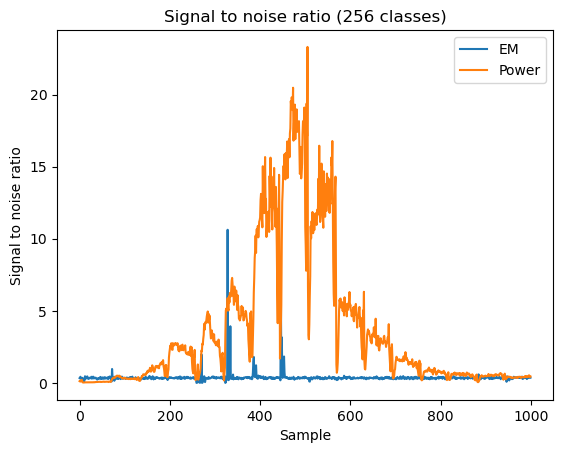

In [22]:
labels_256 = np.load("data/02_labels_p.npy")

snr_em = signal_to_noise(data_em, labels_256)
plt.plot(snr_em, label="EM")

snr_power = signal_to_noise(data_power, labels_256)
plt.plot(snr_power, label="Power")

plt.legend()
plt.xlabel("Sample")
plt.ylabel("Signal to noise ratio")
plt.title("Signal to noise ratio (256 classes)")
plt.show()

We can do the same for a different labeling of the traces (here, with 9 classes):

In [ ]:
labels_9 = np.load("data/02_labels_hw.npy")

snr_em = signal_to_noise(data_em, labels_9)
plt.plot(snr_em, label="EM")

snr_power = signal_to_noise(data_power, labels_9)
plt.plot(snr_power, label="Power")

plt.legend()
plt.xlabel("Sample")
plt.ylabel("Signal to noise ratio")
plt.title("Signal to noise ratio (9 classes)")
plt.show()